<a href="https://colab.research.google.com/github/aadi350/ml-resources/blob/resources/OneClassSVM_for_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine  
A training algorithm that maximizes the margin between training patterns and the decision boundary has been come to known under the general term of **Support Vector Machine**. It was initially proposed in [this 1992 paper](http://www.gautampendse.com/projects/bsvm/webpage/boser1992.pdf) by *Vapnik et. al.* for optical character recognition problems and was applied to a wide variety of classification functions including Perceptrons, Radial-Basis Functions and Polynomials.  

The predictions for new inputs depend **ONLY** on a function evaluated on a subset of training points, or at the extremeties of non-anomalous points. I will not go through the derivation of the Lagrangian Approximation and Quadratic Approximation (big words for "simplify" and "to the power of 2") since this post is focussed on how to implement the OneClassSVM. However, the important practical points to note are that training the OneClassSVM is incredibly compute-intensive, whilst inference can be done incredibly quickly. 

This is because predictions of new inputs depend ONLY on function evaluated on a subset of training points, or on the extremeties of non-anomalous points. The determiniation of model parameters corresponds to convex optimization (any local solution is also a global optimum) which aims to maximize the margin between a particular function and classes of training points. 

To put this visually, an SVM tries to divide the input space with the *maximum-possible* distance between points of different classes and the function, which defines a *separating hyperplane*. When prediction is run on new, previously unseen points, the resulting classification depends on which side of the maximum-margin these new points lie.

In [ ]:
#@title Maximum-Margin Classification
# graph for showing maximum hyper plane

import numpy as np  
import plotly.graph_objects as go 
from sklearn.svm import OneClassSVM, SVC

N = 250

class_1_xs = np.random.normal(loc=5.0, scale=0.3, size=N)  
class_2_xs = np.random.normal(loc=2.0, scale=0.3, size=N)

class_1_ys = np.random.normal(loc=5.0, scale=0.2, size=N)
class_2_ys = np.random.normal(loc=1.0, scale=0.2, size=N)

XS = np.concatenate((class_1_xs, class_2_xs))
YS = np.concatenate((class_1_ys, class_2_ys))

labels = [1 for _ in range(N)] + [0 for _ in range(N)]


fig = go.Figure()
# blue cluster 
fig.add_trace(go.Scatter(
    x=class_1_xs, y=class_1_ys,
    mode='markers',
))

# orange cluster 
fig.add_trace(go.Scatter(
    x=class_2_xs, y=class_2_ys,
    mode='markers',
))


X_in = [(i, j) for i,j in zip(XS, YS)]
clf = SVC(kernel="linear", gamma="auto")

# non-ideal lines
xx = np.linspace(-5, 8)


fig.add_trace(go.Scatter(x=xx, y=-0.3 * xx - (-5), line = dict(color='grey', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=xx, y=-1.3 * xx - (-6), line = dict(color='grey', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=xx, y=0.5 * xx - (-1), line = dict(color='grey', width=1, dash='dash')))

# fit SVM and add line
clf.fit(X_in, labels) 

w = clf.coef_[0]
a = -w[0] / w[1]
yy = a * xx - (clf.intercept_[0]) / w[1]

fig.add_trace(
    go.Scatter(x=xx, y=yy, mode='lines',
    line = dict(color='red', width=4))
)


fig.add_annotation(x=5, y=5.7,
            text="Class 2",
            showarrow=False,
            arrowhead=1)

fig.add_annotation(x=2, y=0.25,
            text="Class 1",
            showarrow=False,
            arrowhead=1)

fig.add_annotation(x=2.69, y=3.472,
            text="Maximum-Margin",
            showarrow=False,
            arrowhead=2)

fig.update_layout(
    showlegend=False,
    autosize=False,
    width=800, 
    height=800,
    template='plotly_dark'
)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 6])

fig.show()



In math terms, the aforementioned quadratic optimization is used to optimize $\textbf{w}$ and $b$ in order to maximize margin distance, where y represents a class and is either $+1$ or $-1$. Maximizing the separating margin equals minimizing maximum loss, which is better than attempting to minimize mean squared error (MSE) since MSE ignores atypical patterns and is not as sensitive to limited computational accuracy.

$$
y(\textbf{x}) = \textbf{w}^T\phi(\textbf{x}) + b
$$

The above method does have a rather nice property however, as alluded to previously, any data point which does not lie on the maximum margin hyperplane can be discarded. In other terms, any data points which are not the *closest* to the separating hyperplane do not necessarily contribute to the position of this hyperplane, and therefore are not necessary for end-predictions

# OneClass SVM
The OneClass SVM is a special form of the typical SVM, which predicts whether or not a new data point belongs to one existing class. Given a distribution $P$, the SVM estimates a subset $S$ of the input space such that the probability of a test point drawn from $P$ lies outside of $S$ equals some a-priori specified value ebtween $0$ and $1$.

A OneClass SVM solution is built estimating a probability distribution function which makes most of the observed data more likely than the rest, and a decision rule that separates these observation by the largest possible margin. Knowledge of density/distribution of "normal" data allows us to solve problems on the basis of data (i.e. whether new test points are anomalous or not).

Additionally, it is not necessary to estimate full density of data (this is severely difficult). Additionally a density only exists if the underlying probability measure possesses an *absolutely continuous* distribtion function. This needs to be simplified for real-world datasets as actual distributions can't be solved. In other terms, fitting neat probability distribution functions adequately to real-world data is computationally and analytically difficult. 

The simplest estimator looks at how many training pionts falls into a particular region of interest. The OneClass SVM starts with a number of training points and estimates a region with the desired property. However, this OneClass method is incredibly sensitive to outliers, as are most maximum-margin classifiers. 

The below image from Vapnik's original paper highlights this sensitivity to outliers, as is evidenced by the stark difference in the position of the separating hyperplanes with the addition and removal of singular points

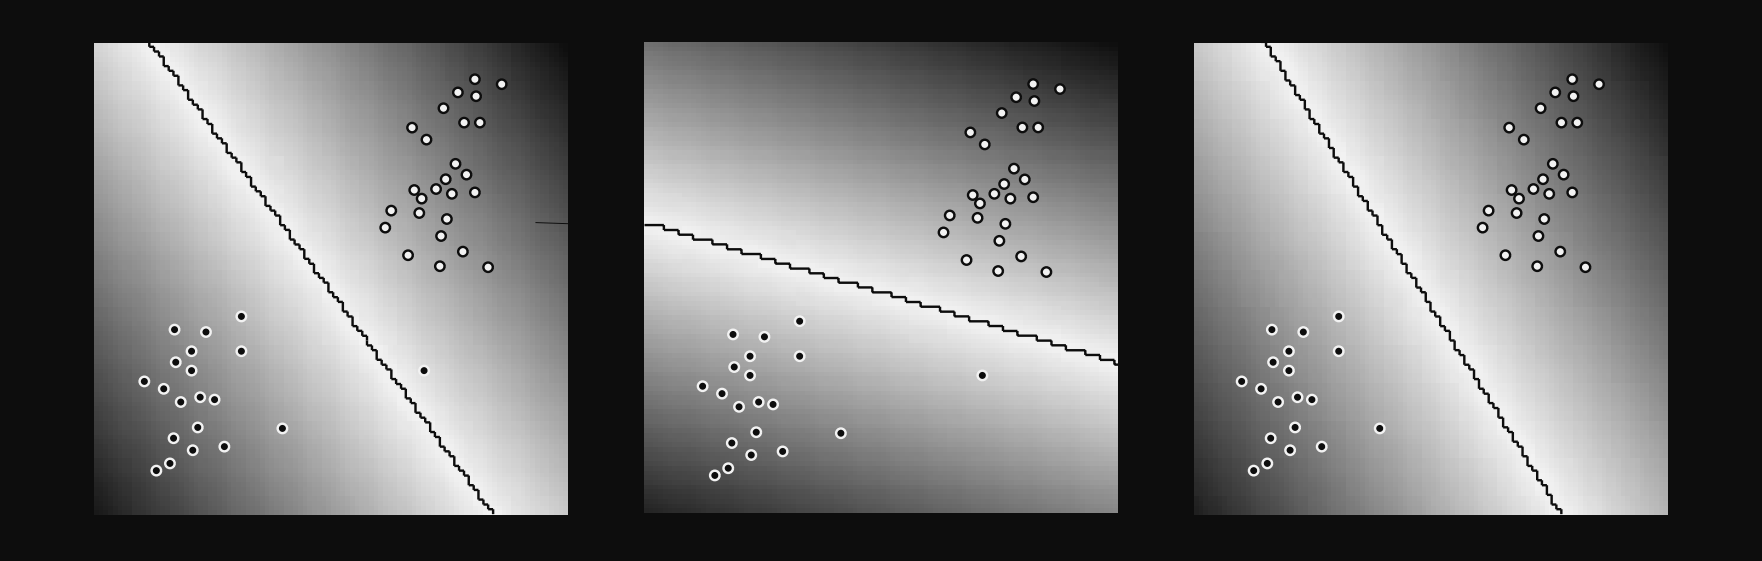


It is therefore highly recommended that the input set contains ONLY clean, or non-anomalous data points


## Hyperparameters  
In order for the OneClassSVM to work properly, we need to specify two key parameters:  
$γ$ - this tells the algorithm whether to follow OR to *approximate* the dataset distributions. In other terms, this parameter tells the algorithm how tightly to "hug" the data.  
$ν$ - this is calculated in the following way:
$$
\hat{ν} = 0.95\times + 0.05
$$
In the above formula, $f$ is the percentage of expected outliers (between 0 and unity). If the purpose of the algorithm is purely for novelty detection, this value should be set to zero


# Implementing a OneClassSVM 

This section shows you how to use Scikit-Learn, using modified code from [the official tutorial](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html). 

Firstly, we must import all required libraries. Additionally, we configure `matplotlib`'s font and set a random state in order to make different runs of the same code equivalent. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM

font = {"weight": "normal", "size": 15}
matplotlib.rc("font", **font)
random_state = 42

Following the above, some training data is generated for out OneClassSVM

In [ ]:
rng = np.random.RandomState(random_state)

# Generate train data
X = 0.3 * rng.randn(500, 2)
X_train = np.r_[X + 2, X - 2]

# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]

# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))
xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))

We set the aforementioned parameters and fit the model using a *radial-basis function* kernel, which allows the OneClassSVM to fit non-linear data.

In [ ]:
nu = 0.05
gamma = 2.0

clf = OneClassSVM(gamma=gamma, kernel="rbf", nu=nu)
clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=2.0, kernel='rbf',
            max_iter=-1, nu=0.05, shrinking=True, tol=0.001, verbose=False)

As is shown below, we've actually used two instances of the OneClassSVM to marginalise two groups of normal (non-anomalous) points.  Additionally, the graph below shows the calculated margins for each OneClassSVM. Any points which lie outside of the red circles are therefore classified as anomalous

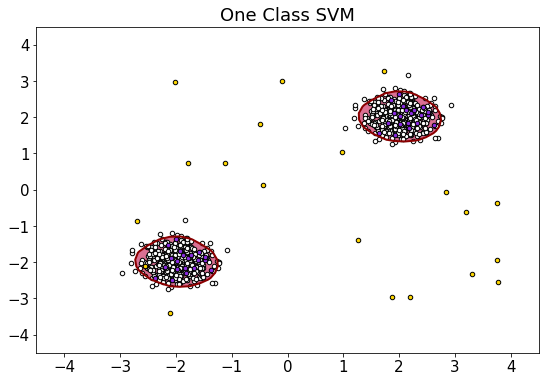

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(9, 6))
plt.title("One Class SVM")
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 20
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")
plt.axis("tight")
plt.xlim((-4.5, 4.5))
plt.ylim((-4.5, 4.5))


plt.show()

Thank you for reading this! This is a fairly new topic to myself, and as I learn more about the field of anomaly detection, I will attempt to simplify it in such a way as to be helpful for an absolute beginniner to understand